[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1GQ0hhMrbGJNPF069SSJ9oJsyH3pR7zjJ#scrollTo=fkFbnLRHrQz4)

# **Flower Classifier using CNNs**

By now, you should have the `flowers` folder in your directory 🌸📁. If not, please follow these steps:  

- 🔗 Visit this [link](<insert-link-here>) and follow the instructions in the `Get Started` notebook.  
- 📥 Alternatively, run the `Oxford 102 Flowers Dataset Loading` notebook to download the dataset.  


## 01. Enviroment Setup

🔌Mount your drive to access project files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


📂 Now, browse to the working directory

In [ ]:
# Your path to FlowerLover
%cd '/content/drive/MyDrive/FlowerLover/'

/content/drive/MyDrive/FlowerLover


📦 Install and import neccesary libraries

In [ ]:
!pip install torch torchvision scikit-learn tqdm &>/dev/null

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image

In [ ]:
import torch
from torch import optim , nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.amp import GradScaler, autocast

from torchvision import datasets , transforms , models

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# Suppress Warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Custom Color Palette
custom_palette = [
    "#5b9e4e", "#a8dba8", "#f0b800", "#f8dd6c", "#f6b176",
    "#f88840", "#e93967", "#d41944", "#c4347c", "#fff2d5",
    "#d9d9d9", "#5ec2c1", "#3a96d9","#fde2e4", "#d3f8f2"]

## 02. Data Preparation and Preprocessing


### Loading the Flower Dataset  📂🌼


In [ ]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

### Prepping data for training, validation, and testing 🖼️🔄


The images are normalized using pre-defined mean and standard deviation values that are commonly used for models trained on the ImageNet dataset. The values are:
- Mean: `[0.485, 0.456, 0.406]` for the RGB channels respectively.
- Standard Deviation: `[0.229, 0.224, 0.225]` for the RGB channels respectively.

The normalization formula for each pixel is:
 `normalized_pixel = (pixel_value - mean) / standard_deviation `

In [ ]:
data_transforms = {

    'train': transforms.Compose([transforms.RandomResizedCrop(224),transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),

    'valid': transforms.Compose([transforms.RandomResizedCrop(256),transforms.CenterCrop(224),
    transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),

    'test': transforms.Compose([transforms.RandomResizedCrop(256),transforms.CenterCrop(224),
    transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
}

image_datasets = {

    'train' : datasets.ImageFolder(train_dir, transform=data_transforms["train"]),
    'valid' : datasets.ImageFolder(valid_dir, transform=data_transforms["valid"]),
    'test' : datasets.ImageFolder(test_dir, transform=data_transforms["test"])

}

dataloaders = {

    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True ,num_workers=2, pin_memory=True),
    'valid': DataLoader(image_datasets['valid'], batch_size=32, num_workers=2, pin_memory=True),
    'test': DataLoader(image_datasets['test'], batch_size=32)

}

In [ ]:
train_loader = dataloaders['train']
valid_loader = dataloaders['valid']
test_loader = dataloaders['test']

### Mapping labels to their respective classes 🏷️🔢


In [ ]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

## 03. Models Training


### Function and Class Definitions 🧰📝

In [ ]:
def define_classifier(input_size, hidden_units=512, output_size=102, dropout_rate=0.5):
    return nn.Sequential(
        nn.Linear(input_size, hidden_units),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(hidden_units, output_size),
        nn.LogSoftmax(dim=1)
    )

In [ ]:
# build and configure the model

def build_model(model_name='resnet50', hidden_units=512, output_size=102, dropout_rate=0.5, custom_classifier=True):
    # Load the pre-trained model
    if model_name == "resnet50":
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    elif model_name == "resnet18":
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    elif model_name == "vgg16":
        model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
    elif model_name == "vgg19":
        model = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
    else:
        raise ValueError("Unsupported model name!")

    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # Define and assign a new classifier only if requested
    if custom_classifier:
        if "resnet" in model_name:
            input_size = model.fc.in_features
            model.fc = define_classifier(input_size, hidden_units, output_size, dropout_rate)
        elif "vgg" in model_name:
            input_size = model.classifier[0].in_features
            model.classifier = define_classifier(input_size, hidden_units, output_size, dropout_rate)

    return model


In [ ]:
# Training setup
def setup_training(model, learning_rate=0.001, optimizer_type="adam", loss_fn_type="nll_loss"):
    # Select optimizer
    optimizers = {
        "adam": optim.Adam,
        "sgd": optim.SGD,
        "adamw": optim.AdamW
    }

    if optimizer_type not in optimizers:
        raise ValueError(f"Unsupported optimizer! Choose from: {list(optimizers.keys())}")

    optimizer = optimizers[optimizer_type](model.parameters(), lr=learning_rate)

    # Select loss function
    loss_fns = {
        "nll_loss": nn.NLLLoss,
        "cross_entropy": nn.CrossEntropyLoss
    }

    if loss_fn_type not in loss_fns:
        raise ValueError(f"Unsupported loss function! Choose from: {list(loss_fns.keys())}")

    criterion = loss_fns[loss_fn_type]()

    return optimizer, criterion


In [ ]:
# Defining Early Stopping : Training stops when the validation loss doesn't improve
class EarlyStopping:
    def __init__(self, patience=5, delta=0.01):

        self.patience = patience
        self.delta = delta
        self.best_loss = np.inf
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [ ]:
# Training function
def train_model(model, optimizer, criterion, train_loader, valid_loader, epochs=15, patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Scaler for mixed precision
    scaler = GradScaler('cuda')

    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

    early_stopping = EarlyStopping(patience=patience)

    # Initializing history dictionary
    history = {
        "train_loss": [],
        "train_accuracy": [],
        "val_loss": [],
        "val_accuracy": []
    }

    for epoch in range(epochs):
        model.train()
        train_accuracy = 0
        running_loss = 0.0

        # Training phase
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as pbar:
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()  # Clearing old gradients
                with autocast('cuda'):  # Mixed precision
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                running_loss += loss.item()

                # Calculate training accuracy for this batch
                top_class = outputs.argmax(dim=1)
                equals = top_class == labels
                train_accuracy += equals.float().mean().item()

                pbar.update(1)

        # Validation phase
        model.eval()
        valid_loss = 0.0
        valid_accuracy = 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                with autocast('cuda'):  # Mixed precision
                    outputs = model(inputs)
                    batch_loss = criterion(outputs, labels)
                    valid_loss += batch_loss.item()

                    # Validation accuracy calculation
                    top_class = outputs.argmax(dim=1)
                    equals = top_class == labels
                    valid_accuracy += equals.float().mean().item()

        # Calculate epoch statistics
        train_loss = running_loss / len(train_loader)
        train_acc = train_accuracy / len(train_loader)
        val_loss = valid_loss / len(valid_loader)
        val_acc = valid_accuracy / len(valid_loader)

        # Append epoch statistics to history
        history["train_loss"].append(train_loss)
        history["train_accuracy"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_acc)

        # Print epoch statistics
        print(f"Epoch {epoch+1}/{epochs}.. "
              f"Train loss: {train_loss:.3f}.. "
              f"Train accuracy: {train_acc:.3f}.. "
              f"Validation loss: {val_loss:.3f}.. "
              f"Validation accuracy: {val_acc:.3f}")

        # Learning rate scheduler step
        scheduler.step(val_loss)

        # Check for early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break

    return model, history, optimizer


### Training Models with Consistent Configurations 🤖🏋️‍♂️


In [ ]:
# List of model configurations
model_configs = ["resnet50", "resnet18", "vgg16", "vgg19"]

learning_rate = 0.001
optimizer_type = "adam"
loss_function = "nll_loss"
epochs = 15
patience = 7  # Early stopping patience

# Store histories , trained models and optimizers
all_histories = {}
trained_models = {}
all_optimizers = {}

# Training each model
for model_name in model_configs:
    print(f"Training {model_name}:")

    model = build_model(model_name,custom_classifier=True)
    optimizer, criterion = setup_training(model, learning_rate, optimizer_type, loss_function)
    model, history, optimizer = train_model(model, optimizer, criterion, train_loader, valid_loader, epochs=epochs)

    trained_models[model_name] = model
    all_histories[model_name] = history
    all_optimizers[model_name] = optimizer

    print("-" * 50)


Training resnet50:


Epoch 1/15: 100%|██████████| 205/205 [00:33<00:00,  6.04batch/s]


Epoch 1/15.. Train loss: 3.038.. Train accuracy: 0.350.. Validation loss: 1.568.. Validation accuracy: 0.693


Epoch 2/15: 100%|██████████| 205/205 [00:31<00:00,  6.50batch/s]


Epoch 2/15.. Train loss: 1.338.. Train accuracy: 0.678.. Validation loss: 0.870.. Validation accuracy: 0.805


Epoch 3/15: 100%|██████████| 205/205 [00:44<00:00,  4.64batch/s]


Epoch 3/15.. Train loss: 0.931.. Train accuracy: 0.759.. Validation loss: 0.757.. Validation accuracy: 0.834


Epoch 4/15: 100%|██████████| 205/205 [00:43<00:00,  4.72batch/s]


Epoch 4/15.. Train loss: 0.742.. Train accuracy: 0.807.. Validation loss: 0.588.. Validation accuracy: 0.860


Epoch 5/15: 100%|██████████| 205/205 [00:43<00:00,  4.70batch/s]


Epoch 5/15.. Train loss: 0.653.. Train accuracy: 0.827.. Validation loss: 0.530.. Validation accuracy: 0.878


Epoch 6/15: 100%|██████████| 205/205 [00:43<00:00,  4.69batch/s]


Epoch 6/15.. Train loss: 0.567.. Train accuracy: 0.850.. Validation loss: 0.503.. Validation accuracy: 0.874


Epoch 7/15: 100%|██████████| 205/205 [00:43<00:00,  4.69batch/s]


Epoch 7/15.. Train loss: 0.543.. Train accuracy: 0.859.. Validation loss: 0.452.. Validation accuracy: 0.889


Epoch 8/15: 100%|██████████| 205/205 [00:43<00:00,  4.75batch/s]


Epoch 8/15.. Train loss: 0.475.. Train accuracy: 0.872.. Validation loss: 0.456.. Validation accuracy: 0.886


Epoch 9/15: 100%|██████████| 205/205 [00:44<00:00,  4.64batch/s]


Epoch 9/15.. Train loss: 0.481.. Train accuracy: 0.870.. Validation loss: 0.471.. Validation accuracy: 0.872


Epoch 10/15: 100%|██████████| 205/205 [00:30<00:00,  6.82batch/s]


Epoch 10/15.. Train loss: 0.426.. Train accuracy: 0.878.. Validation loss: 0.432.. Validation accuracy: 0.894


Epoch 11/15: 100%|██████████| 205/205 [00:30<00:00,  6.66batch/s]


Epoch 11/15.. Train loss: 0.424.. Train accuracy: 0.882.. Validation loss: 0.427.. Validation accuracy: 0.888


Epoch 12/15: 100%|██████████| 205/205 [00:40<00:00,  5.07batch/s]


Epoch 12/15.. Train loss: 0.413.. Train accuracy: 0.884.. Validation loss: 0.363.. Validation accuracy: 0.919


Epoch 13/15: 100%|██████████| 205/205 [00:43<00:00,  4.75batch/s]


Epoch 13/15.. Train loss: 0.376.. Train accuracy: 0.897.. Validation loss: 0.442.. Validation accuracy: 0.884


Epoch 14/15: 100%|██████████| 205/205 [00:42<00:00,  4.87batch/s]


Epoch 14/15.. Train loss: 0.382.. Train accuracy: 0.896.. Validation loss: 0.447.. Validation accuracy: 0.882


Epoch 15/15: 100%|██████████| 205/205 [00:42<00:00,  4.79batch/s]


Epoch 15/15.. Train loss: 0.376.. Train accuracy: 0.892.. Validation loss: 0.401.. Validation accuracy: 0.901
--------------------------------------------------
Training resnet18:


Epoch 1/15: 100%|██████████| 205/205 [00:42<00:00,  4.84batch/s]


Epoch 1/15.. Train loss: 3.450.. Train accuracy: 0.244.. Validation loss: 2.015.. Validation accuracy: 0.546


Epoch 2/15: 100%|██████████| 205/205 [00:41<00:00,  4.94batch/s]


Epoch 2/15.. Train loss: 1.900.. Train accuracy: 0.523.. Validation loss: 1.238.. Validation accuracy: 0.735


Epoch 3/15: 100%|██████████| 205/205 [00:41<00:00,  4.89batch/s]


Epoch 3/15.. Train loss: 1.426.. Train accuracy: 0.624.. Validation loss: 1.032.. Validation accuracy: 0.743


Epoch 4/15: 100%|██████████| 205/205 [00:41<00:00,  4.93batch/s]


Epoch 4/15.. Train loss: 1.239.. Train accuracy: 0.667.. Validation loss: 0.856.. Validation accuracy: 0.799


Epoch 5/15: 100%|██████████| 205/205 [00:41<00:00,  4.98batch/s]


Epoch 5/15.. Train loss: 1.111.. Train accuracy: 0.699.. Validation loss: 0.767.. Validation accuracy: 0.808


Epoch 6/15: 100%|██████████| 205/205 [00:42<00:00,  4.87batch/s]


Epoch 6/15.. Train loss: 1.027.. Train accuracy: 0.714.. Validation loss: 0.704.. Validation accuracy: 0.843


Epoch 7/15: 100%|██████████| 205/205 [00:41<00:00,  4.93batch/s]


Epoch 7/15.. Train loss: 0.980.. Train accuracy: 0.730.. Validation loss: 0.684.. Validation accuracy: 0.813


Epoch 8/15: 100%|██████████| 205/205 [00:42<00:00,  4.87batch/s]


Epoch 8/15.. Train loss: 0.933.. Train accuracy: 0.736.. Validation loss: 0.688.. Validation accuracy: 0.818


Epoch 9/15: 100%|██████████| 205/205 [00:41<00:00,  4.89batch/s]


Epoch 9/15.. Train loss: 0.904.. Train accuracy: 0.745.. Validation loss: 0.654.. Validation accuracy: 0.829


Epoch 10/15: 100%|██████████| 205/205 [00:42<00:00,  4.86batch/s]


Epoch 10/15.. Train loss: 0.880.. Train accuracy: 0.752.. Validation loss: 0.585.. Validation accuracy: 0.856


Epoch 11/15: 100%|██████████| 205/205 [00:41<00:00,  4.97batch/s]


Epoch 11/15.. Train loss: 0.847.. Train accuracy: 0.757.. Validation loss: 0.679.. Validation accuracy: 0.816


Epoch 12/15: 100%|██████████| 205/205 [00:41<00:00,  4.91batch/s]


Epoch 12/15.. Train loss: 0.845.. Train accuracy: 0.761.. Validation loss: 0.629.. Validation accuracy: 0.845


Epoch 13/15: 100%|██████████| 205/205 [00:41<00:00,  4.92batch/s]


Epoch 13/15.. Train loss: 0.849.. Train accuracy: 0.766.. Validation loss: 0.618.. Validation accuracy: 0.863


Epoch 14/15: 100%|██████████| 205/205 [00:42<00:00,  4.81batch/s]


Epoch 14/15.. Train loss: 0.724.. Train accuracy: 0.790.. Validation loss: 0.519.. Validation accuracy: 0.868


Epoch 15/15: 100%|██████████| 205/205 [00:42<00:00,  4.82batch/s]


Epoch 15/15.. Train loss: 0.669.. Train accuracy: 0.810.. Validation loss: 0.553.. Validation accuracy: 0.856
--------------------------------------------------
Training vgg16:


Epoch 1/15: 100%|██████████| 205/205 [00:43<00:00,  4.72batch/s]


Epoch 1/15.. Train loss: 3.083.. Train accuracy: 0.306.. Validation loss: 1.594.. Validation accuracy: 0.600


Epoch 2/15: 100%|██████████| 205/205 [00:48<00:00,  4.26batch/s]


Epoch 2/15.. Train loss: 1.904.. Train accuracy: 0.511.. Validation loss: 1.334.. Validation accuracy: 0.646


Epoch 3/15: 100%|██████████| 205/205 [00:43<00:00,  4.68batch/s]


Epoch 3/15.. Train loss: 1.642.. Train accuracy: 0.574.. Validation loss: 1.095.. Validation accuracy: 0.711


Epoch 4/15: 100%|██████████| 205/205 [00:43<00:00,  4.69batch/s]


Epoch 4/15.. Train loss: 1.510.. Train accuracy: 0.605.. Validation loss: 1.128.. Validation accuracy: 0.713


Epoch 5/15: 100%|██████████| 205/205 [00:43<00:00,  4.71batch/s]


Epoch 5/15.. Train loss: 1.477.. Train accuracy: 0.615.. Validation loss: 0.934.. Validation accuracy: 0.744


Epoch 6/15: 100%|██████████| 205/205 [00:44<00:00,  4.61batch/s]


Epoch 6/15.. Train loss: 1.419.. Train accuracy: 0.631.. Validation loss: 1.011.. Validation accuracy: 0.739


Epoch 7/15: 100%|██████████| 205/205 [00:44<00:00,  4.60batch/s]


Epoch 7/15.. Train loss: 1.365.. Train accuracy: 0.648.. Validation loss: 0.917.. Validation accuracy: 0.759


Epoch 8/15: 100%|██████████| 205/205 [00:43<00:00,  4.70batch/s]


Epoch 8/15.. Train loss: 1.351.. Train accuracy: 0.652.. Validation loss: 0.958.. Validation accuracy: 0.746


Epoch 9/15: 100%|██████████| 205/205 [00:43<00:00,  4.68batch/s]


Epoch 9/15.. Train loss: 1.315.. Train accuracy: 0.664.. Validation loss: 0.871.. Validation accuracy: 0.762


Epoch 10/15: 100%|██████████| 205/205 [00:43<00:00,  4.69batch/s]


Epoch 10/15.. Train loss: 1.292.. Train accuracy: 0.668.. Validation loss: 0.891.. Validation accuracy: 0.777


Epoch 11/15: 100%|██████████| 205/205 [00:44<00:00,  4.63batch/s]


Epoch 11/15.. Train loss: 1.310.. Train accuracy: 0.667.. Validation loss: 0.985.. Validation accuracy: 0.739


Epoch 12/15: 100%|██████████| 205/205 [01:22<00:00,  2.49batch/s]


Epoch 12/15.. Train loss: 1.298.. Train accuracy: 0.667.. Validation loss: 0.957.. Validation accuracy: 0.765


Epoch 13/15: 100%|██████████| 205/205 [00:29<00:00,  7.02batch/s]


Epoch 13/15.. Train loss: 1.133.. Train accuracy: 0.703.. Validation loss: 0.785.. Validation accuracy: 0.796


Epoch 14/15: 100%|██████████| 205/205 [00:30<00:00,  6.82batch/s]


Epoch 14/15.. Train loss: 0.996.. Train accuracy: 0.732.. Validation loss: 0.821.. Validation accuracy: 0.801


Epoch 15/15: 100%|██████████| 205/205 [00:29<00:00,  6.97batch/s]


Epoch 15/15.. Train loss: 0.978.. Train accuracy: 0.740.. Validation loss: 0.808.. Validation accuracy: 0.780
--------------------------------------------------
Training vgg19:


Epoch 1/15: 100%|██████████| 205/205 [00:51<00:00,  4.00batch/s]


Epoch 1/15.. Train loss: 3.206.. Train accuracy: 0.278.. Validation loss: 1.870.. Validation accuracy: 0.539


Epoch 2/15: 100%|██████████| 205/205 [00:31<00:00,  6.56batch/s]


Epoch 2/15.. Train loss: 2.063.. Train accuracy: 0.474.. Validation loss: 1.438.. Validation accuracy: 0.652


Epoch 3/15: 100%|██████████| 205/205 [00:32<00:00,  6.40batch/s]


Epoch 3/15.. Train loss: 1.784.. Train accuracy: 0.534.. Validation loss: 1.222.. Validation accuracy: 0.669


Epoch 4/15: 100%|██████████| 205/205 [00:30<00:00,  6.66batch/s]


Epoch 4/15.. Train loss: 1.663.. Train accuracy: 0.568.. Validation loss: 1.149.. Validation accuracy: 0.709


Epoch 5/15: 100%|██████████| 205/205 [00:31<00:00,  6.58batch/s]


Epoch 5/15.. Train loss: 1.580.. Train accuracy: 0.589.. Validation loss: 1.082.. Validation accuracy: 0.720


Epoch 6/15: 100%|██████████| 205/205 [00:33<00:00,  6.09batch/s]


Epoch 6/15.. Train loss: 1.452.. Train accuracy: 0.617.. Validation loss: 1.015.. Validation accuracy: 0.735


Epoch 7/15: 100%|██████████| 205/205 [00:31<00:00,  6.45batch/s]


Epoch 7/15.. Train loss: 1.443.. Train accuracy: 0.622.. Validation loss: 0.960.. Validation accuracy: 0.741


Epoch 8/15: 100%|██████████| 205/205 [00:32<00:00,  6.40batch/s]


Epoch 8/15.. Train loss: 1.433.. Train accuracy: 0.626.. Validation loss: 0.965.. Validation accuracy: 0.747


Epoch 9/15: 100%|██████████| 205/205 [00:33<00:00,  6.09batch/s]


Epoch 9/15.. Train loss: 1.399.. Train accuracy: 0.635.. Validation loss: 1.014.. Validation accuracy: 0.748


Epoch 10/15: 100%|██████████| 205/205 [00:31<00:00,  6.46batch/s]


Epoch 10/15.. Train loss: 1.406.. Train accuracy: 0.633.. Validation loss: 1.019.. Validation accuracy: 0.739


Epoch 11/15: 100%|██████████| 205/205 [00:31<00:00,  6.53batch/s]


Epoch 11/15.. Train loss: 1.208.. Train accuracy: 0.679.. Validation loss: 0.931.. Validation accuracy: 0.748


Epoch 12/15: 100%|██████████| 205/205 [00:31<00:00,  6.49batch/s]


Epoch 12/15.. Train loss: 1.100.. Train accuracy: 0.699.. Validation loss: 0.854.. Validation accuracy: 0.784


Epoch 13/15: 100%|██████████| 205/205 [00:31<00:00,  6.52batch/s]


Epoch 13/15.. Train loss: 1.068.. Train accuracy: 0.711.. Validation loss: 0.881.. Validation accuracy: 0.775


Epoch 14/15: 100%|██████████| 205/205 [00:31<00:00,  6.49batch/s]


Epoch 14/15.. Train loss: 1.019.. Train accuracy: 0.720.. Validation loss: 0.822.. Validation accuracy: 0.792


Epoch 15/15: 100%|██████████| 205/205 [00:31<00:00,  6.57batch/s]


Epoch 15/15.. Train loss: 0.991.. Train accuracy: 0.732.. Validation loss: 0.794.. Validation accuracy: 0.790
--------------------------------------------------


### Plotting training/validation loss and accuracy for all models 📉📈

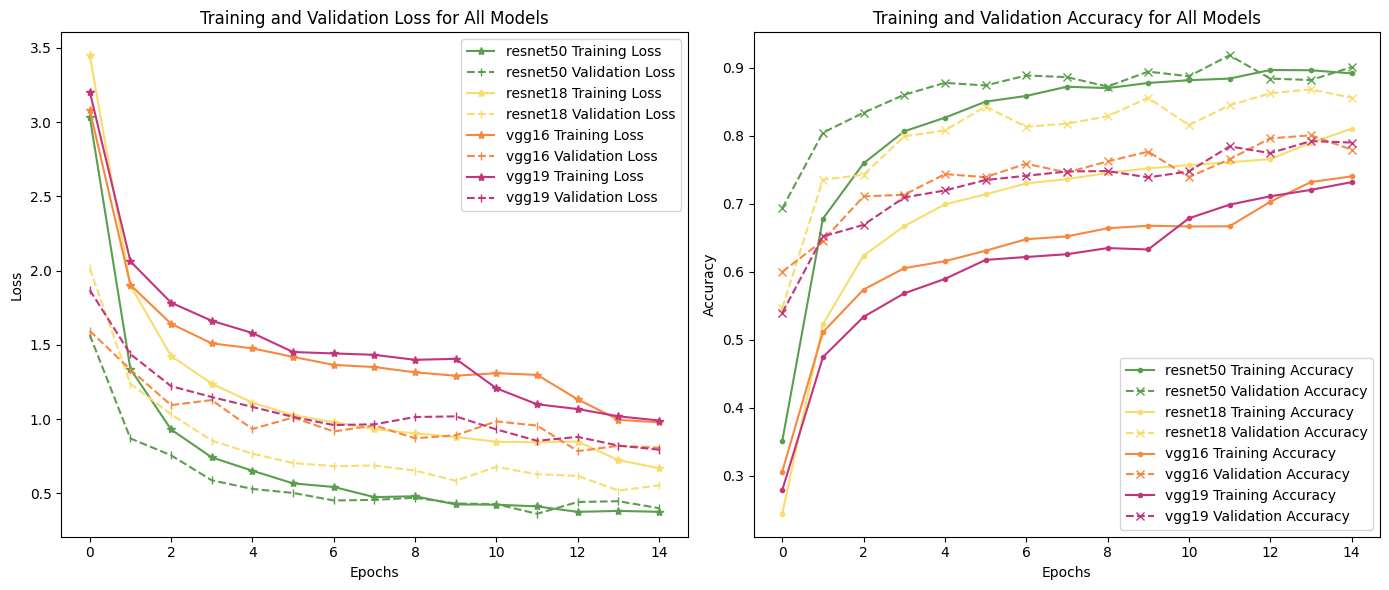

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

colors=[custom_palette[i] for i in [0,3,5,8]]

# Plotting Loss in the first subplot
for i, (model_name, history) in enumerate(all_histories.items()):
    ax1.plot(history["train_loss"], label=f"{model_name} Training Loss", color=colors[i], marker='*')
    ax1.plot(history["val_loss"], label=f"{model_name} Validation Loss", linestyle="--", color=colors[i], marker='|')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training and Validation Loss for All Models")
ax1.legend()

# Plotting Accuracy in the second subplot
for i, (model_name, history) in enumerate(all_histories.items()):
    ax2.plot(history["train_accuracy"], label=f"{model_name} Training Accuracy", color=colors[i], marker='.')
    ax2.plot(history["val_accuracy"], label=f"{model_name} Validation Accuracy", linestyle="--", color=colors[i], marker='x')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("Training and Validation Accuracy for All Models")
ax2.legend()

plt.tight_layout()
plt.show()


## 04. Models Testing

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dictionary to store evaluation metrics
metrics_summary = []

# Evaluate each model
for model_name, model in trained_models.items():
    print(f"Evaluating {model_name}...")

    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    # Collect predictions and true labels
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            preds = outputs.argmax(dim=1)  # Get the predicted class
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute evaluation metrics
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="weighted", zero_division=1)
    recall = recall_score(all_labels, all_preds, average="weighted", zero_division=1)
    f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=1)

    # Add metrics to the summary list
    metrics_summary.append({
        "Model": model_name,
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    })

print("-" * 50)

# Convert metrics summary to DataFrame for display
metrics_df = pd.DataFrame(metrics_summary)

# Display the table
print("Evaluation Metrics:")
display(metrics_df)


Evaluating resnet50...
Evaluating resnet18...
Evaluating vgg16...
Evaluating vgg19...
--------------------------------------------------
Evaluation Metrics:


,Model,Accuracy,Precision,Recall,F1 Score
0,resnet50,0.884005,0.899693,0.884005,0.882830
1,resnet18,0.841270,0.858366,0.841270,0.840450
2,vgg16,0.781441,0.789329,0.781441,0.785363
3,vgg19,0.760684,0.776586,0.760684,0.760244


## 05. Saving Checkpoints 🗂️💾

In [ ]:
# Directory to save the models
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)  # Ensure the directory exists


metadata = {'learning_rate': learning_rate,'optimizer_type': optimizer_type,'loss_function': loss_function,'earlystopping_patience': patience}

# Save models
for model_name, model in trained_models.items():
    save_path = os.path.join(save_dir, f"{model_name}_checkpoint.pth")

    # Save the model's state and metadata
    checkpoint = {
        'model_name': model_name,
        'model_state_dict': model.state_dict(),
        'class_to_idx': image_datasets['train'].class_to_idx,
        'optimizer_state_dict': all_optimizers[model_name].state_dict(),
        'training_metadata': metadata
        }

    # Handling different models
    if 'resnet' in model_name:
        checkpoint['classifier'] = model.fc  # For ResNet models
    elif 'vgg' in model_name:
        checkpoint['classifier'] = model.classifier  # For VGG models

    torch.save(checkpoint, save_path)
    print(f"Saved {model_name} to {save_path}")


Saved resnet50 to saved_models\resnet50_checkpoint.pth
Saved resnet18 to saved_models\resnet18_checkpoint.pth
Saved vgg16 to saved_models\vgg16_checkpoint.pth
Saved vgg19 to saved_models\vgg19_checkpoint.pth


## 06. Inference for Classification


### Loading Model Checkpoints 🗃️🔄


In [ ]:
def load_model(checkpoint_path):

    # Map the checkpoint to the appropriate device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Build the model (without redefining the classifier)
    model = build_model(model_name=checkpoint['model_name'], custom_classifier=False)

    # Attach the saved classifier
    if "resnet" in checkpoint['model_name']:
        model.fc = checkpoint['classifier']
    elif "vgg" in checkpoint['model_name']:
        model.classifier = checkpoint['classifier']

    # Load the model weights
    model.load_state_dict(checkpoint['model_state_dict'], strict=False)

    model.class_to_idx = checkpoint['class_to_idx']


    return model


In [ ]:
vgg16 = load_model('saved_models/vgg16_checkpoint.pth')
vgg19 = load_model('saved_models/vgg19_checkpoint.pth')
resnet18 = load_model('saved_models/resnet18_checkpoint.pth')
resnet50 = load_model('saved_models/resnet50_checkpoint.pth')

models = {'vgg16':vgg16, 'vgg19':vgg19, 'resnet18':resnet18, 'resnet50':resnet50}

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 141MB/s]
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 168MB/s]
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 174MB/s]
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 133MB/s]


### Processing Input Image 🖼️

In [ ]:
def process_image(image):

    image = Image.open(image)  # Open image if a path is provided

    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    return preprocess(image)

In [ ]:
def imshow(image, ax=None, title=None, normalize=True):

    if ax is None:
        _ , ax = plt.subplots()

    # PyTorch tensors expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array
    # Thus, reordering dimensions using transpose
    image = image.numpy().transpose((1, 2, 0)) # Convert from (C, H, W) to (H, W, C)

    if normalize:
        # Reverse normalization (undo preprocessing)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)  # Clip the image values to the range [0, 1] to prevent display artifacts or noise

    ax.imshow(image)
    ax.axis('off')
    if title:
        ax.set_title(title)

    return ax


### Top-K Prediction 🥇

In [ ]:
# Predicting top-K most probable classes

def predict(image_path, model,top_k=5):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    tensor_image = process_image(image_path)
    tensor_image = tensor_image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(tensor_image)

    probabilities = torch.softmax(output, dim=1)
    top_probs, top_indices = probabilities.topk(top_k)

    top_probs = top_probs.squeeze().cpu().numpy()
    top_indices = top_indices.squeeze().cpu().numpy()

    idx_to_class = {value: key for key, value in model.class_to_idx.items()}
    classes = [idx_to_class[idx] for idx in top_indices]

    return top_probs, classes

### Sanity check across multiple models for comparison 🧠🧪

In [ ]:
def sanity_checking(image_path, models, top_k=5):

    # Extract real species name from image path
    label = image_path.split('/')[-2]  # Extract the label from the path
    real_species_name = cat_to_name.get(label, "Unknown Species")  # Map to species name

    num_models = len(models)

    # Create subplots dynamicly : one for the image and one for each model
    _, axes = plt.subplots(1, num_models + 1, figsize=(5 * (num_models + 1), 5))

    img = process_image(image_path)

    # Displaying the processed inputted image
    imshow(img, ax=axes[0], title=f"Flower Type: {real_species_name}")

    # Looping through models
    for idx, (model_name, model) in enumerate(models.items(), start=1):

        probs, classes = predict(image_path, model, top_k)
        class_names = [cat_to_name.get(str(cls)) for cls in classes]

        y_pos = np.arange(len(class_names))
        axes[idx].barh(y_pos, probs, align='center', color=custom_palette[:top_k])
        axes[idx].set_yticks(y_pos)
        axes[idx].set_yticklabels(class_names)
        axes[idx].invert_yaxis()  # Highest probability at the top
        axes[idx].set_xlabel('Probability')
        axes[idx].set_title(f"Model: {model_name}")

    plt.tight_layout()
    plt.show()


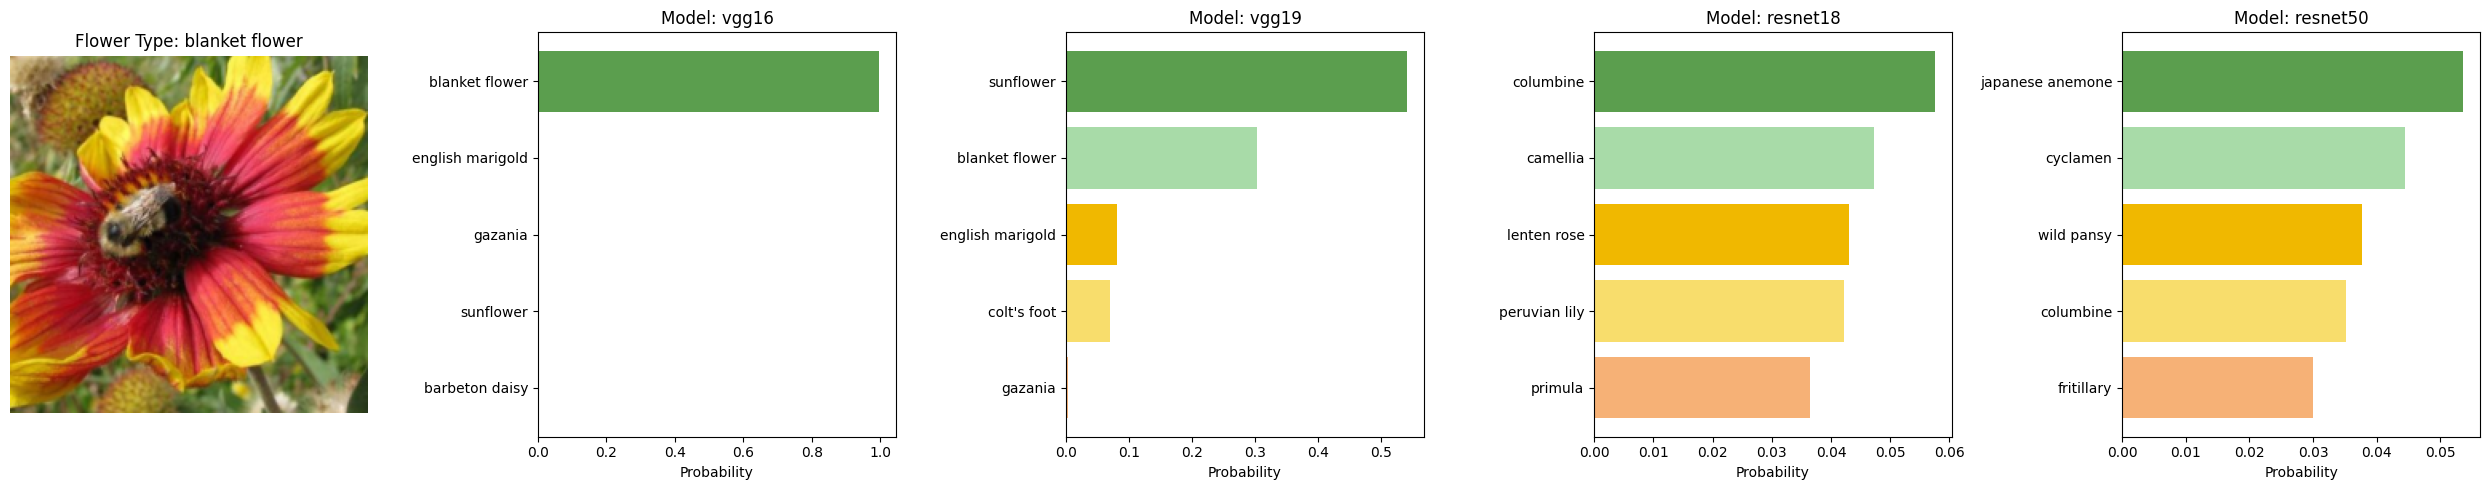

In [ ]:
sanity_checking('flowers/test/100/image_07896.jpg', models)

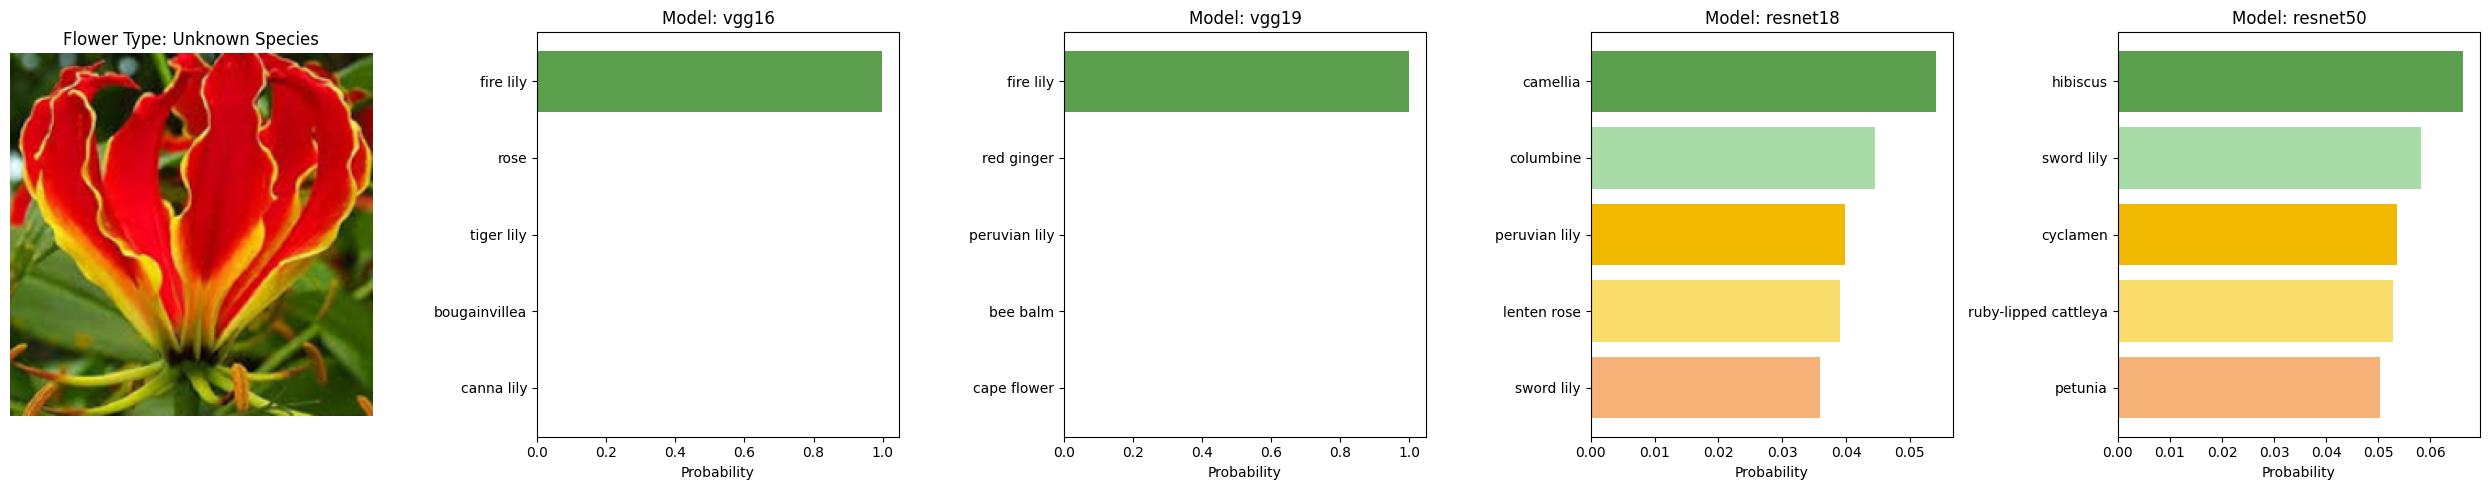

In [ ]:
sanity_checking('assets/download.jpg', models)

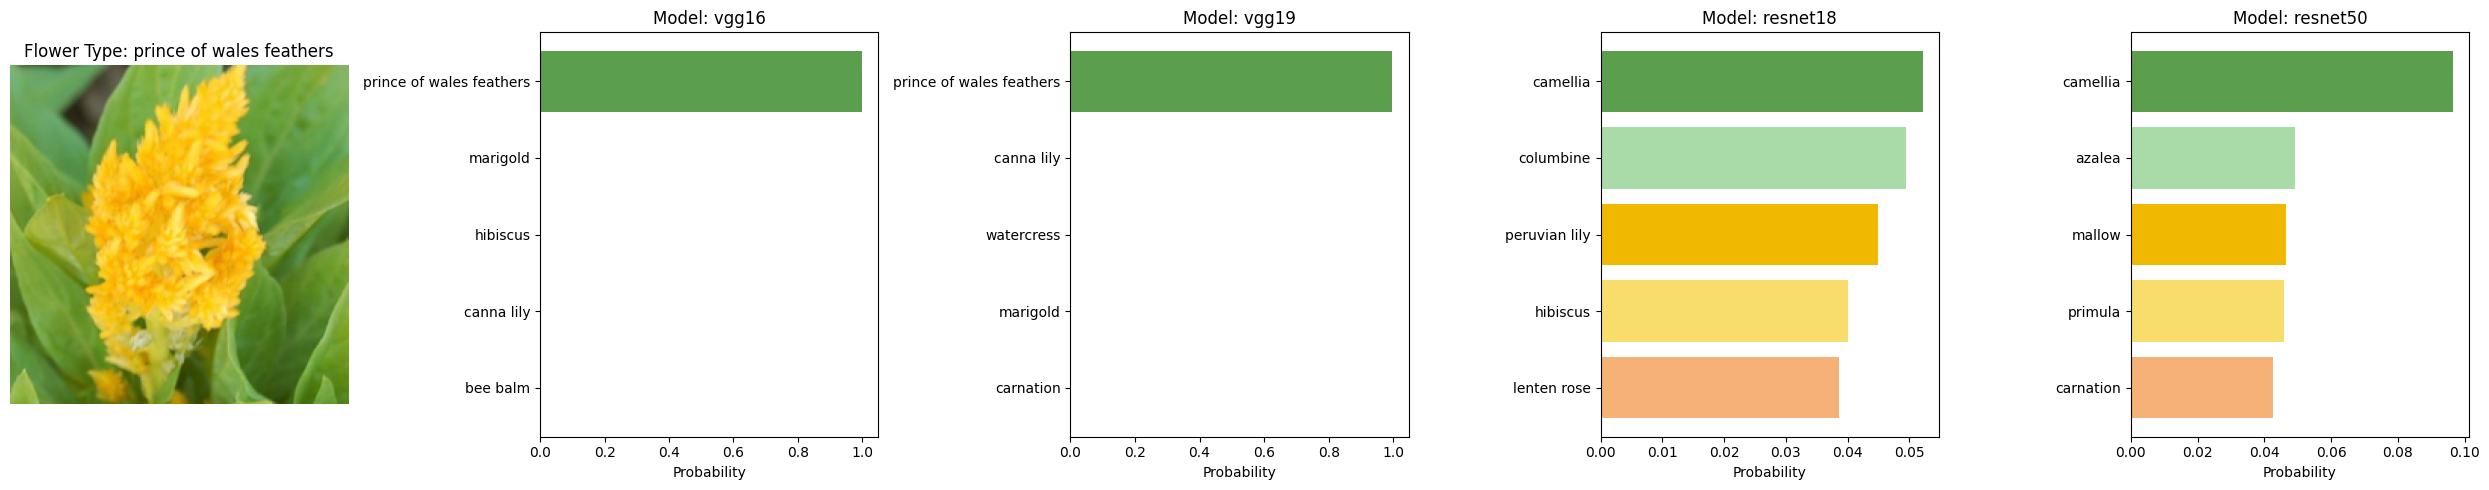

In [ ]:
sanity_checking('flowers/test/27/image_06864.jpg', models)

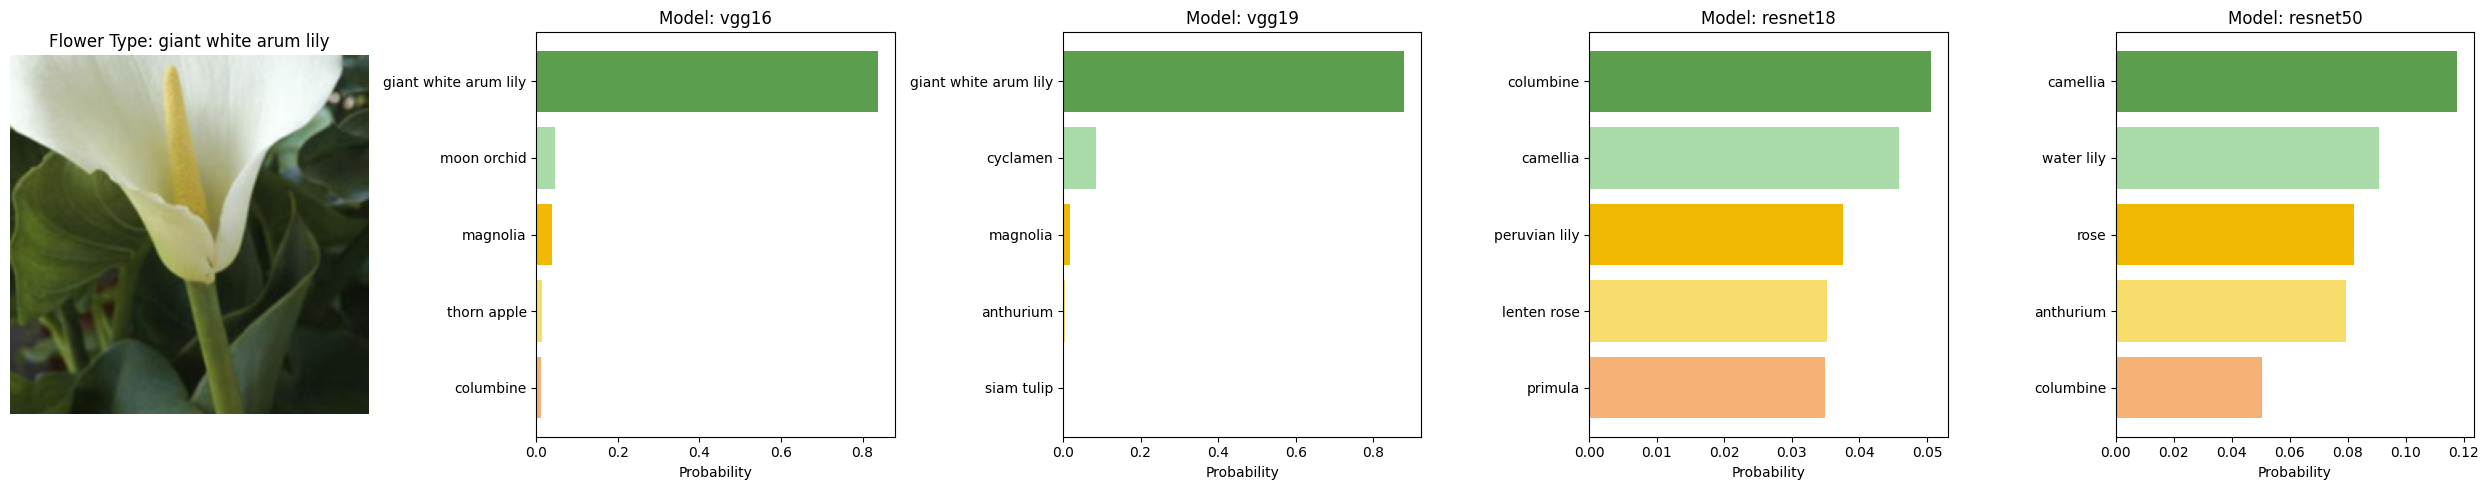

In [ ]:
sanity_checking('flowers/test/20/image_04910.jpg', models)

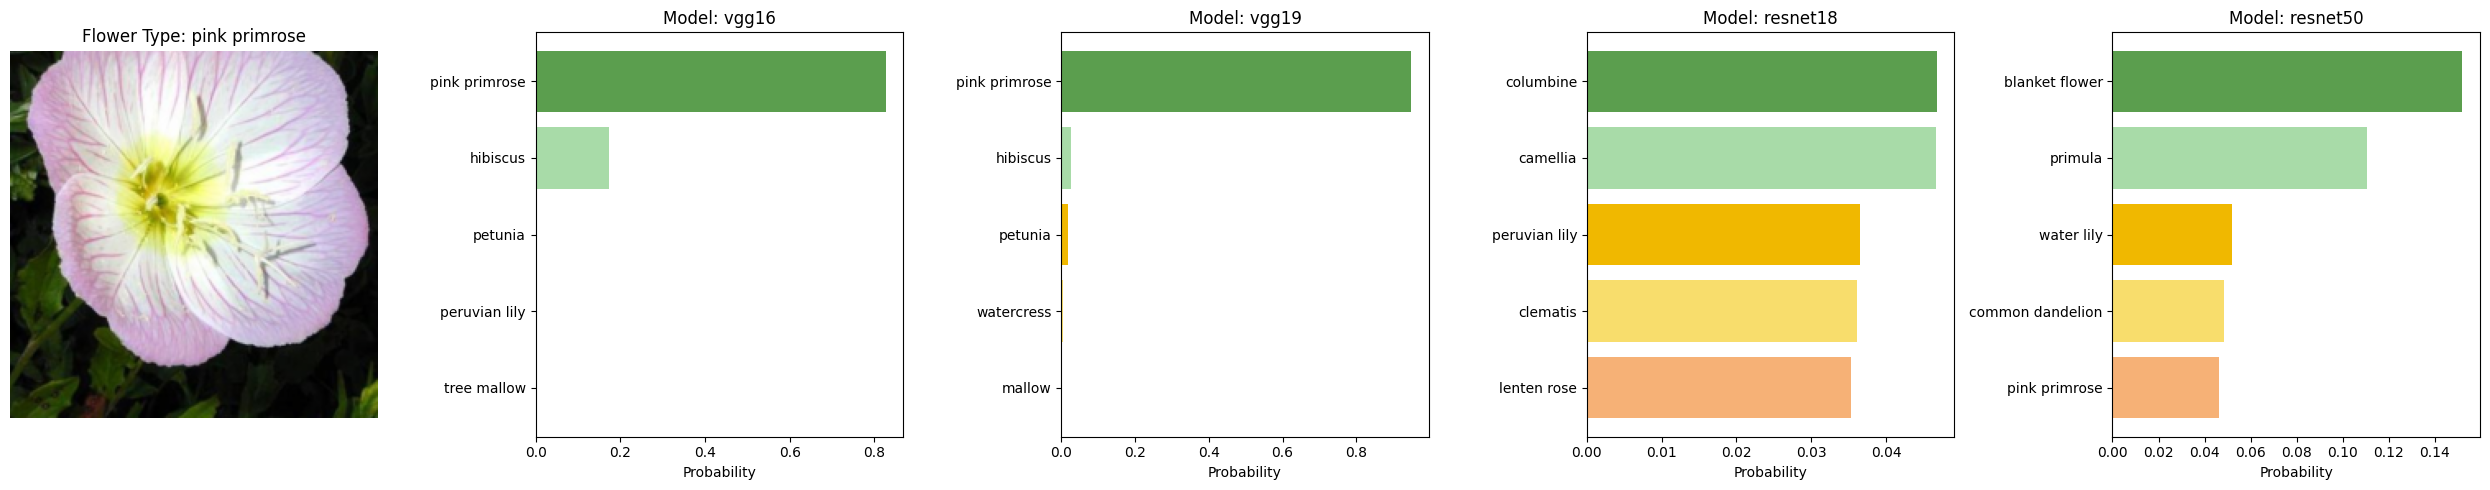

In [ ]:
sanity_checking('flowers/test/1/image_06743.jpg', models)

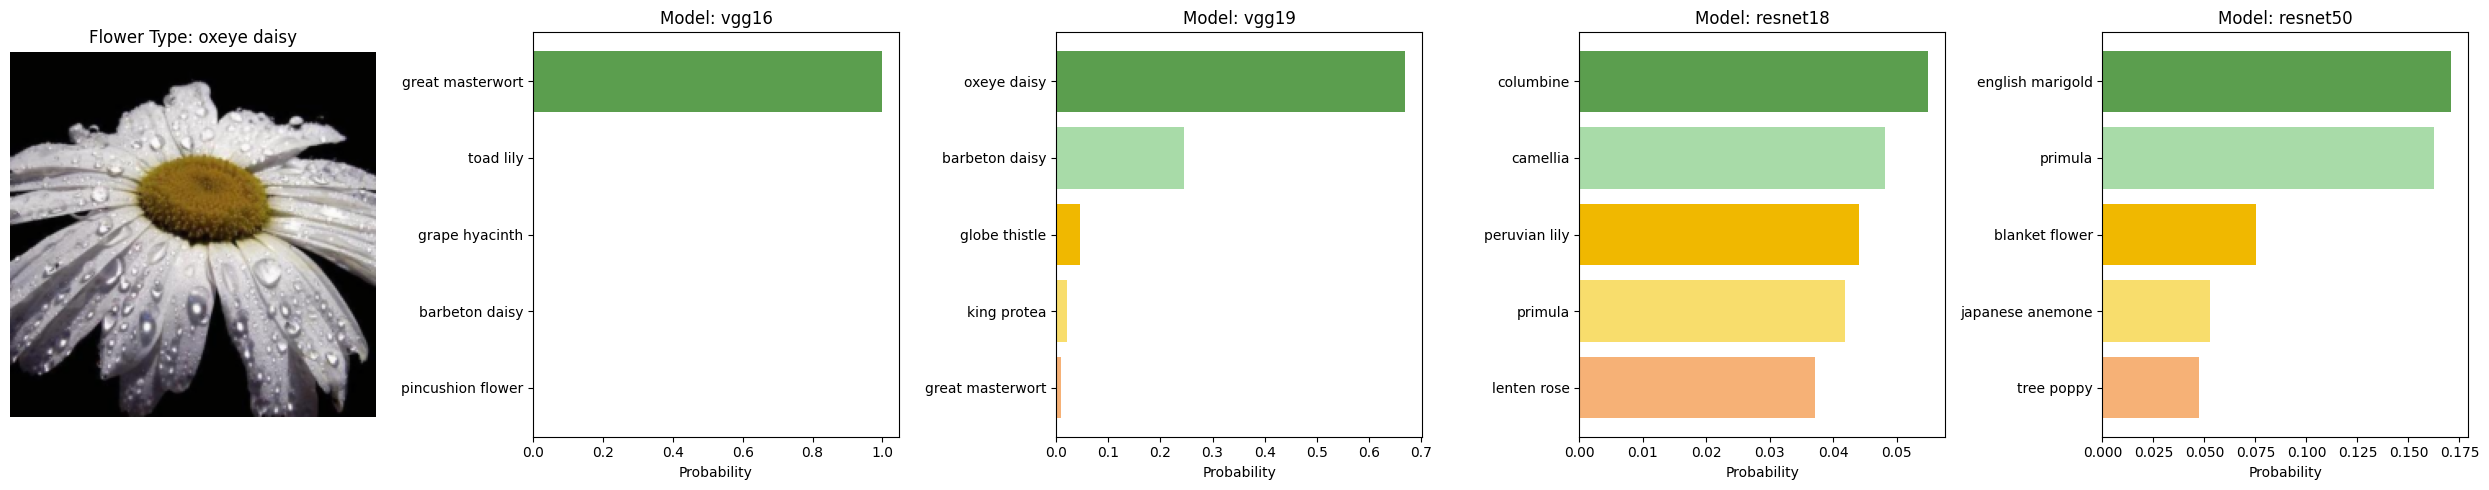

In [ ]:
sanity_checking('flowers/test/49/image_06202.jpg', models)

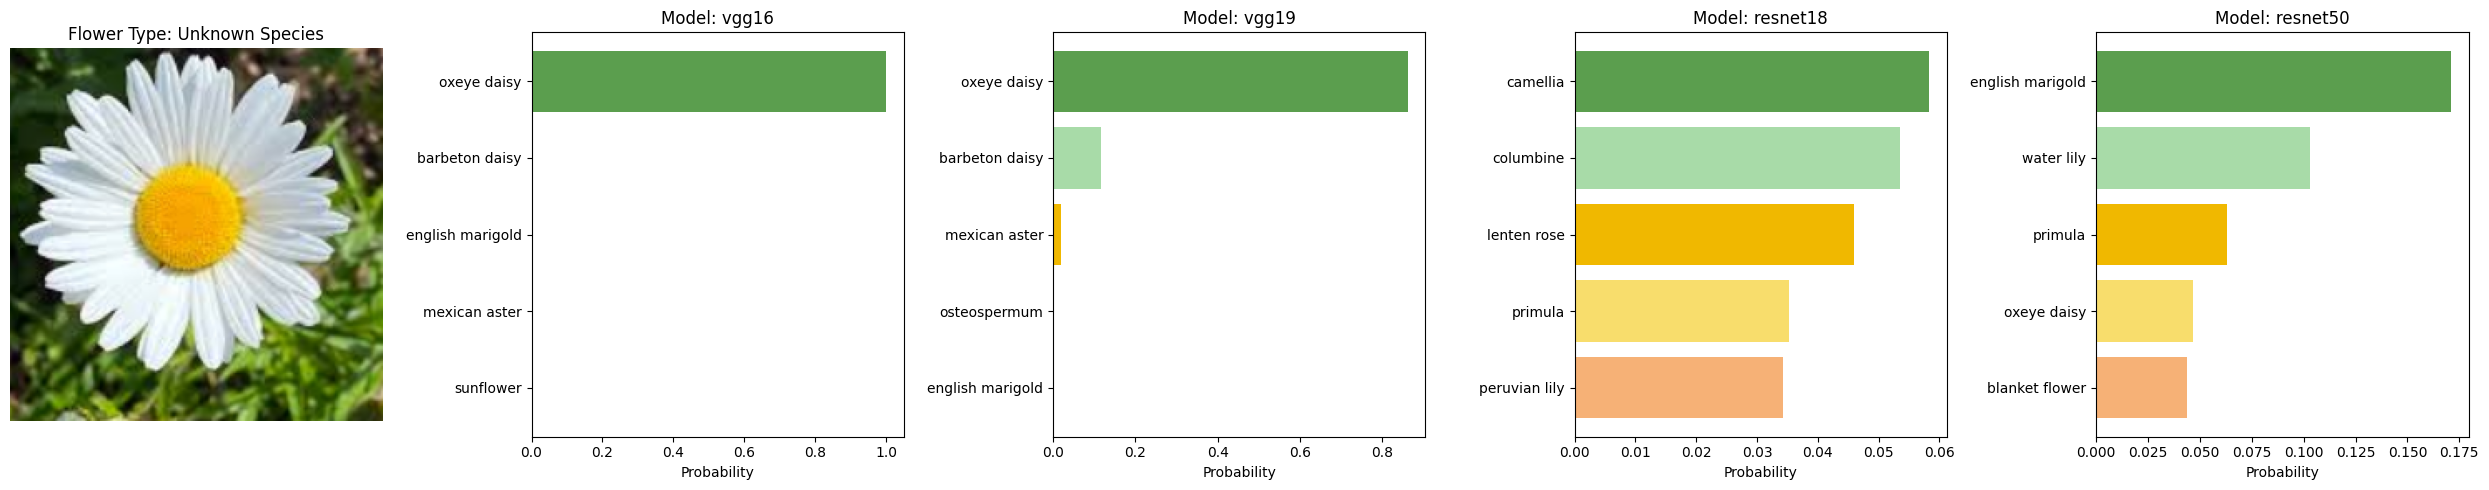

In [ ]:
sanity_checking('assets/download1.jpg', models)

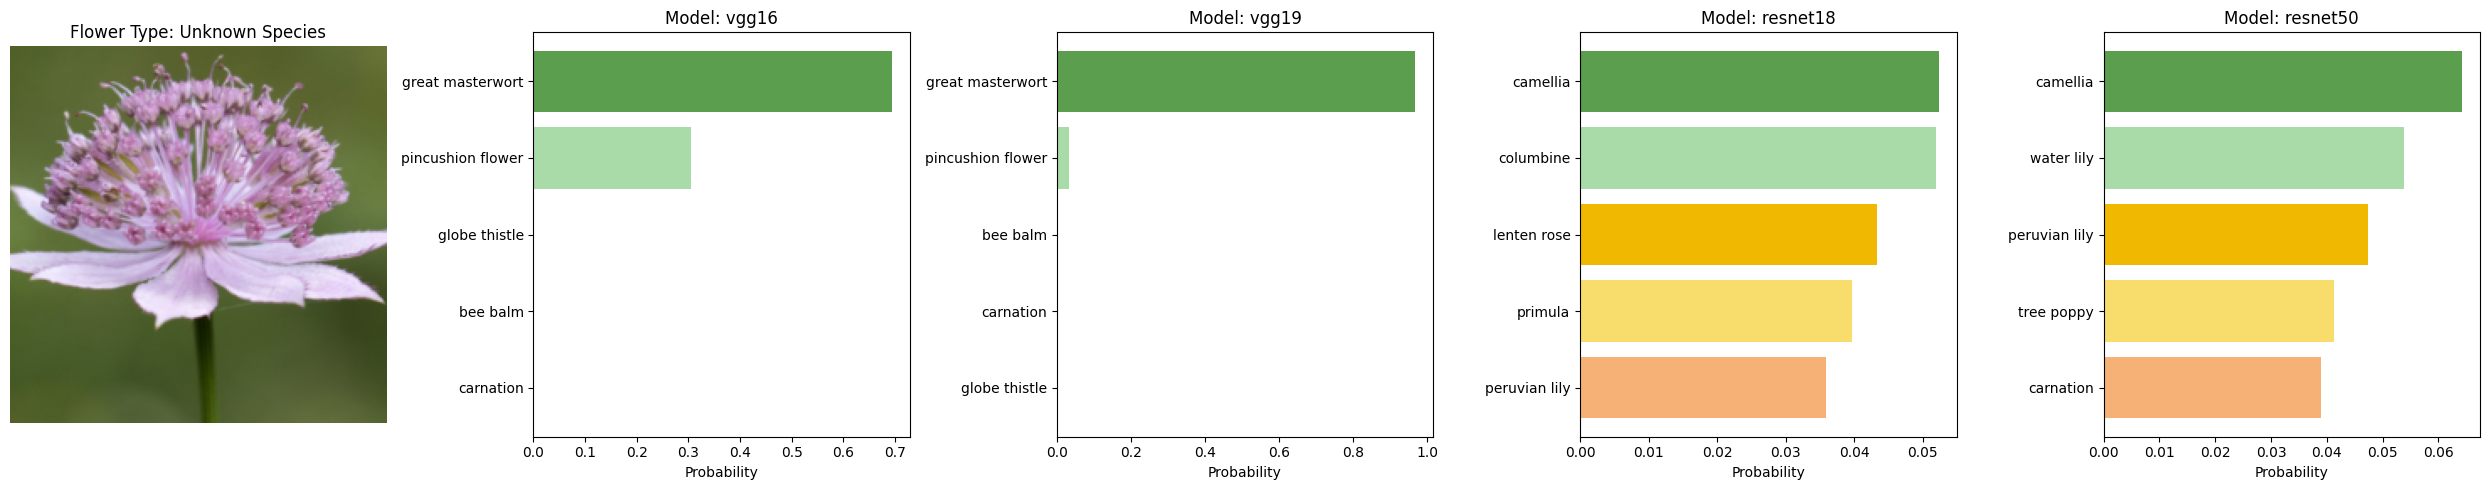

In [ ]:
sanity_checking('assets/download2.jpg', models)

## 07. Final Thoughts  
In this notebook, some popular CNN models like VGG18, ResNet18 and ResNet50 were tested out to classify different flower species🌻🌷. Some models, like VGG16, really nailed it with certain flowers , while others had a bit of a harder time with tricky cases.

Next up, we're diving into **Vision Transformers (ViTs)** 👀🤖. These models a have been making waves for their ability to focus on the right features with attention mechanisms.

Will they outshine CNNs on our flower dataset?🤔 <br>

Let’s find out in the next notebook `Flower Classifier - ViT`.

